# Reinforcement Learning

This tutorial will walk through some initial concepts and algorithms for reinforcement learning (RL). I'll assume you've already done the general introduction on supervised learning with Tensorflow. We'll start with basic Q-learning to introduce the concept of RL, but you will need to be familiar with Tensorflow models for some of the later algorithms.

Additionally, the focus of this tutorial will be on RL in control applications. We'll start by introducing some basic concepts followed by an example with the pendulum problem.

## Markov Decision Process (MDP)

Reinfocement learning problems seek to find a solution to an MDP which maximizes a reward. An MDP is represented by a set of states $S$, a set of actions $A$, a reward function $R(s_t,a_t,s_{t+1}) : S \times A \times S \rightarrow \mathbb{R}$, and a transition function $P(s_t,a_t,s_{t+1}) : S \times A \times S \rightarrow [0,1]$. The reward function maps a transition $(s_t,a_t,s_{t+1})$ to a scalar reward. In many cases this may be simplified to a function of state-action pairs $(s_t,a_t)$ or just state. The transition function returns the probability that a state-action pair $(s_t,a_t)$ will result in a given state $s_{t+1}$. A solution to an MDP is a policy $\pi(a_t|s_t) : A \times S \rightarrow \mathbb{R}$ which gives the probability of an action $a_t$ given the current state $s_t$. For deterministic policies this may also be written as $\mu(s_t) : S \rightarrow A$ which returns an action given the current state.

MDPs often have a discount factor $0 \leq \gamma < 1$ to weight immediate rewards more favorably than future rewards. In this case the objective of the policy is to maximize the return of a trajectory $\tau = \{ (s_0, a_0), (s_1, a_1), ..., (s_T, a_T)\}$. The return is defined as $G = \sum_{t=0}^{T-1} \gamma^t R(s_t, a_t, s_{t+1})$.

## Control Theory

Control problems can usually be modeled as an MDP with some minor tweaks and typically different notation. For notation, the state space is often denoted as $X$ and the action space is called the control space denoted as $U$. The reward function is also typically replaced with a cost function $J(x,u)$ which we wish to minimize. The transition function is analogous to the system dynamics $\dot{x} = f(x,u,w,t)$. We'll mostly be working with deterministic, time-invariant systems represented by the simplified expression $\dot{x} = f(x,u)$. The following notebook will be dealing with simulations and numerical algorithms, so it's also convenient to work with a discrete-time representation $x_{t+1} = f(x_t, u_t)$. In this representation the parallels to MDPs should be fairly obvious. 

## Value Iteration

Value iteration is one algorithm for solving MDPs if the transition and reward functions are known. Understanding how it works will provide some insight into the RL algorithms we discuss later, which have no direct access to the transition or reward function. Value iteration is based on the principal of optimality. In simple terms, this states that the tail end of any optimal trajectory is also optimal. In more mathematical terms, if you have an optimal trajectory from $x_0$ to $x_T$ which passes through $x_t$ then the portion of that trajectory from $x_t$ to $x_T$ is the optimal solution from $x_t$. This is the basic for dynamic programming methods, which typically find optimal solutions by working backwards from the goal finding optimal solutions to subproblems. Value iteration does this by iteratively solving the following equation:

$V_{i+1}(s_t) = \max_{a_t} \sum_{s_{t+1}}P(s_t, a_t, s_{t+1})\left[R(s_t, a_t, s_{t+1}) + \gamma V_i(s_{t+1})\right]$

In the discrete case, this is guaranteed to converge to an optimal solution $V^*$ which has the following property:

$V^*(s_t) = \max_{a_t} \sum_{s_{t+1}}P(s_t, a_t, s_{t+1})\left[R(s_t, a_t, s_{t+1}) + \gamma V^*(s_{t+1})\right]$

The optimal policy for the MDP is given by:

$\pi^*(s_t) = \arg\max_{a_t} \sum_{s_{t+1}}P(s_t, a_t, s_{t+1})\left[R(s_t, a_t, s_{t+1}) + \gamma V^*(s_{t+1})\right]$

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gym
import time

from IPython import display

%matplotlib inline

## Loading Gym Environments

OpenAI's Gym has a range of environments designed for RL experiments load in and use out-of-the-box. These environments include a simple cartpole problem. This environment gives the position and velocity of the cart and the angle and angular rate of the pendulum as the observation. There are two possible actions for the agent: push left or push right. The agent receives a reward of +1 every time step until the cart position or pendulum angle pass a given threshold. 

In [2]:
env = gym.make("Pendulum-v1")

print("Observation:", env.observation_space)
print("Action:", env.action_space)

Observation: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Action: Box([-2.], [2.], (1,), float32)


We can quickly visualize this environment to see how an agent is performing. Since we don't yet have an agent, we'll just sample actions randomly. Of course, this policy won't last long before failing.

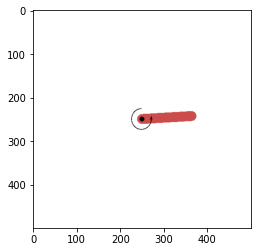

In [3]:
env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
done = False
while not done:
    action = env.action_space.sample()
    _, _, done, _ = env.step(action)
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
env.close()

## Q-Learning

We start by solving this environment with the Q-learning algorithm. This isn't a *Deep* RL algorithm, but it provides a more clear example of the principles that later algorithms will be working off of. 

The objective of Q-Learning (and many algorithms we explore later) is to learn a q-function which $Q : S \times A \rightarrow \mathbb{R}$ predicts the value for taking an action at a given state. This is similar to the value function in Value Iteration, but determines the value for state-action pairs instead of state alone. Similarly to value iteration, the optimal q-function should satisfy the following condition:

$Q^*(s_t, a_t) = \sum_{s_{t+1}} P(s_t, a_t, s_{t+t}) \left[R(s_t, a_t, s_{t+1}) + \gamma \max_{a_{t+1}} Q^*(s_{t+1}, a_{t+1})\right]$

Regular Q-Learning represents this function as a look-up table and learns each value through dynamic programming. Since we don't have access to the transition function or reward function, we have to learn this function by sampling experience. Experience is sampled from the environment as transitions in the form $(s_t, a_t, s_{t+1})$. Each time new experience is sampled, the Q value is updated by the equation:

$Q(s_t, a_t) \leftarrow (1 - \alpha) Q(s_t, a_t) + \alpha \left[R(s_t, a_t, s_{t+1}) + \gamma \max_a Q(s_{t+1}, a)\right]$

The learning rate $\alpha$ is typically a small value which can be adjusted to change how fast the q-function is updated. This soft update allows the q-function to approximate stochastic transitions. The pendulum environment is deterministic, but we need to discretize the state space to create a tabular q-function. The soft update helps since our discretized state space doesn't perfectly represent the actual state.

In [27]:
theta = np.linspace(-np.pi, np.pi, 21)
thetadot = np.arange(-8, 7.6, .5)
thetadot[0] = -np.inf # Setting first entry to neg. infinity for numerical errors

print("theta:", theta)
print("thetadot:", thetadot)

N = theta.shape[0]*thetadot.shape[0]

print("N:", N)

Q = np.zeros((N,3))

def state_map(obs):
    angle = np.arctan2(obs[1], obs[0])
    i = np.nonzero(theta <= angle)[0][-1]
    j = np.nonzero(thetadot <= obs[2])[0][-1]
    
    return j + i*thetadot.shape[0]

def action_map(action):
    if action == 0:
        return np.array([-2])
    elif action == 1:
        return np.array([0])
    else:
        return np.array([2])

theta: [-3.14159265 -2.82743339 -2.51327412 -2.19911486 -1.88495559 -1.57079633
 -1.25663706 -0.9424778  -0.62831853 -0.31415927  0.          0.31415927
  0.62831853  0.9424778   1.25663706  1.57079633  1.88495559  2.19911486
  2.51327412  2.82743339  3.14159265]
thetadot: [-inf -7.5 -7.  -6.5 -6.  -5.5 -5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5
 -1.  -0.5  0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5
  6.   6.5  7.   7.5]
N: 672


In [28]:
print(state_map([-1, -0.001, -8]))
print(state_map([np.cos(-2.6), np.sin(-2.6), -8]))
print(state_map([-1, 0, -7.4]))

print(action_map(0))
print(action_map(1))
print(action_map(2))

0
32
641
[-2]
[0]
[2]


Now we just need to collect some experience and update our Q function until it converges on a successful policy. Feel free to run the following cell a few times until the total return is at a satisfactory value. (Note this probably won't acheive a particularly high score. Just train it until it can reach a score of 100 every once in a while).

In [42]:
lr = 0.1
for i in range(100):
    print("Episode", i)
    obs = env.reset()
    total_return = 0
    done = False
    while not done:
        ind = state_map(obs)
        if np.random.rand() > .2:
            action = np.argmax(Q[ind])
        else:
            action = np.random.randint(3)
        obs, reward, done, _ = env.step(action_map(action))
        total_return += reward

        Q[ind, action] = (1 - lr) * Q[ind, action] + lr * (reward + 0.99 * np.max(Q[state_map(obs)]))
    print("Total return:", total_return)

env.close()

Episode 0
Total return: -381.5415588095833
Episode 1
Total return: -623.8190069295432
Episode 2
Total return: -748.0620876034568
Episode 3
Total return: -374.5873348590019
Episode 4
Total return: -635.6661592066587
Episode 5
Total return: -744.8051013099672
Episode 6
Total return: -126.36726749240648
Episode 7
Total return: -608.4058701534519
Episode 8
Total return: -490.4911026004222
Episode 9
Total return: -368.14152708182047
Episode 10
Total return: -251.4697137676263
Episode 11
Total return: -616.7708352909402
Episode 12
Total return: -648.3177695298467
Episode 13
Total return: -379.73448745500156
Episode 14
Total return: -380.09451831415697
Episode 15
Total return: -237.72955350357745
Episode 16
Total return: -824.0895109426322
Episode 17
Total return: -254.2110737472445
Episode 18
Total return: -243.19367181234455
Episode 19
Total return: -451.78642946398935
Episode 20
Total return: -635.1523562833295
Episode 21
Total return: -497.9901153673096
Episode 22
Total return: -508.95695

Now that we've trained a Q function we can visualize how well it performs.

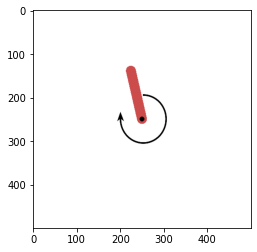

In [43]:
obs = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
done = False
while not done:
    ind = state_map(obs)
    action = np.argmax(Q[ind])
    obs, reward, done, _ = env.step(action_map(action))

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
env.close()